In [178]:
import csv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import community as community_louvain
import seaborn as sns
import json
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score,log_loss
from sklearn.preprocessing import StandardScaler
from graphrole import RecursiveFeatureExtractor, RoleExtractor
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.cluster import KMeans


%matplotlib inline
np.random.seed(42)


## Role Extration

In [116]:
def load_data_from_csv(file_path):
    data = []
    with open(file_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip the header row
        for row in reader:
            data.append((row[0], row[1]))
    return data

Github_file = './git_web_ml/musae_git_edges.csv'
raw_data = load_data_from_csv(Github_file)

In [118]:
# Create a undirected graph
Github_graph = nx.Graph()

# Add edges from the dataset
for edge in raw_data:
    Github_graph.add_edge(edge[0], edge[1])
    
Github_graph = nx.convert_node_labels_to_integers(Github_graph, label_attribute='old_label')

In [120]:
# if the graph is connected
if nx.is_connected(Github_graph):
     Github_graph = Github_graph

else:
    largest_cc = max(nx.connected_components(Github_graph), key=len)
    subgraph =  Github_graph.subgraph(largest_cc).copy()
    Github_graph = subgraph


In [121]:
# Louvain: Community detection
partition = community_louvain.best_partition(Github_graph)

In [122]:
# Calculate the modularity of the overall network
total_modularity = community_louvain.modularity(partition, Github_graph)

In [123]:
# Get all Communities
communities = {}
for node, community in partition.items():
    if community not in communities:
        communities[community] = []
    communities[community].append(node)

In [124]:
# Calculate the modularity contribution for each community
def calculate_community_modularity_contribution(community_nodes, graph, partition):
    subgraph = graph.subgraph(community_nodes)
    sub_partition = {node: partition[node] for node in community_nodes}
    community_modularity = community_louvain.modularity(sub_partition, subgraph)
    return community_modularity

community_modularity_contributions = {}
for community_id, nodes in communities.items():
    modularity_contribution = calculate_community_modularity_contribution(nodes, Github_graph, partition)
    community_modularity_contributions[community_id] = modularity_contribution

# Select the community with the greatest modularity contribution
most_contributive_community_id = max(community_modularity_contributions, key=community_modularity_contributions.get)
most_contributive_community_nodes = communities[most_contributive_community_id]
sub_graph = Github_graph.subgraph(most_contributive_community_nodes)


In [170]:
transitivity = nx.transitivity(sub_graph)
average_clustering = nx.average_clustering(sub_graph)
average_clustering

0.1425591811384846

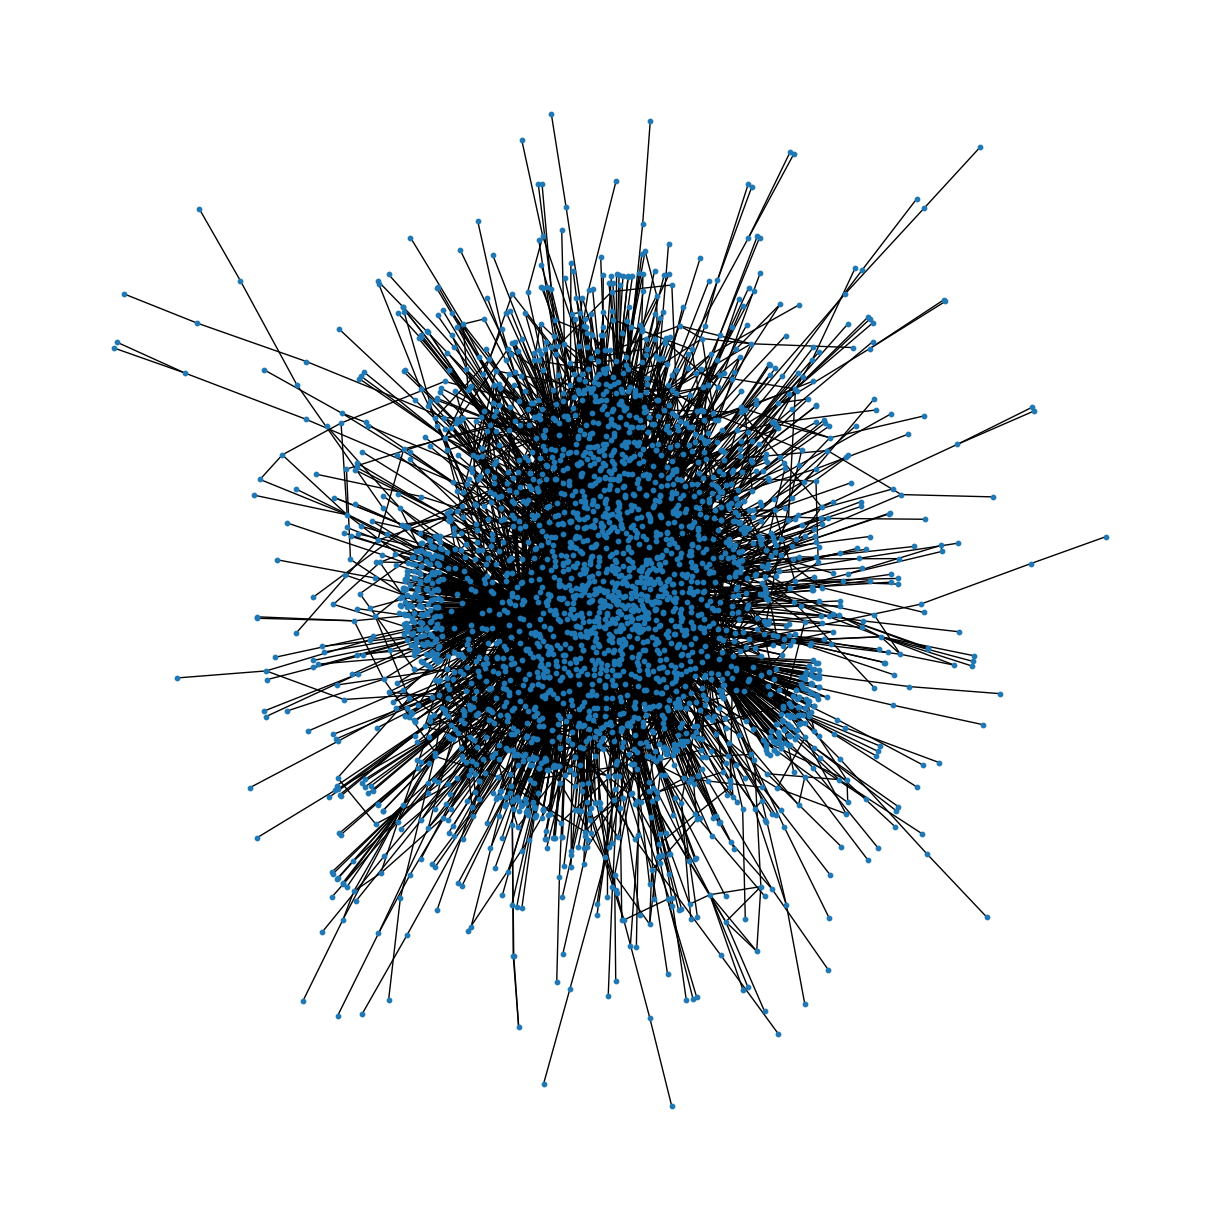

In [126]:
pos = nx.spring_layout(sub_graph, seed=42) 
plt.figure(figsize=(12,12))
nx.draw(sub_graph,pos,node_size = 10)
plt.savefig('Github_network.jpg', format='jpg', dpi=300)

In [127]:
class RecursiveFeatureExtractor:
    def __init__(self, graph):
        self.graph = graph
        
    def extract_local_features(self):
        local_features = {}
        for node in sorted(self.graph.nodes()):
             degree = self.graph.degree(node)
             local_features[node] = [degree]
        return local_features

    def extract_egonet_features(self):
        egonet_features = {}
        for node in self.graph.nodes():
            egonet = nx.ego_graph(self.graph, node)
            egonet_size = len(egonet)
            egonet_edges = egonet.number_of_edges()
            avg_degree = np.mean([deg for _, deg in egonet.degree()])
            avg_clustering = nx.average_clustering(egonet)
            egonet_features[node] = [egonet_size, egonet_edges, avg_degree, avg_clustering]
        return egonet_features

    def extract_recursive_features(self, local_features, egonet_features):
        recursive_features = {}
        for node in self.graph.nodes():
            neighbors = list(self.graph.neighbors(node))
            if neighbors:
                avg_local = np.mean([local_features[neighbor] for neighbor in neighbors], axis=0)
                avg_egonet = np.mean([egonet_features[neighbor] for neighbor in neighbors], axis=0)
                recursive_features[node] = np.concatenate((avg_local, avg_egonet))
            else:
                recursive_features[node] = np.zeros(len(list(local_features.values())[0]) + len(list(egonet_features.values())[0]))
        return recursive_features

    def extract_features(self):
        local_features = self.extract_local_features()
        egonet_features = self.extract_egonet_features()
        recursive_features = self.extract_recursive_features(local_features, egonet_features)
        feature_matrix = np.array([recursive_features[node] for node in self.graph.nodes])
        return feature_matrix, list(sorted(self.graph.nodes()))



In [128]:
# Feature Extration
feature_extractor = RecursiveFeatureExtractor(sub_graph)
features, nodes = feature_extractor.extract_features()
features

array([[2.00000000e+01, 2.10000000e+01, 2.60000000e+01, 2.47619048e+00,
        3.82456140e-01],
       [1.08500000e+01, 1.18500000e+01, 2.27500000e+01, 2.82820308e+00,
        3.72060424e-01],
       [1.16250000e+01, 1.26250000e+01, 2.25000000e+01, 2.88765263e+00,
        4.00353115e-01],
       ...,
       [5.00000000e+00, 6.00000000e+00, 5.00000000e+00, 1.66666667e+00,
        0.00000000e+00],
       [1.07333333e+02, 1.08333333e+02, 3.25500000e+02, 2.99013435e+00,
        2.69723034e-01],
       [9.72500000e+01, 9.82500000e+01, 2.07500000e+02, 3.64532739e+00,
        4.29687071e-01]])

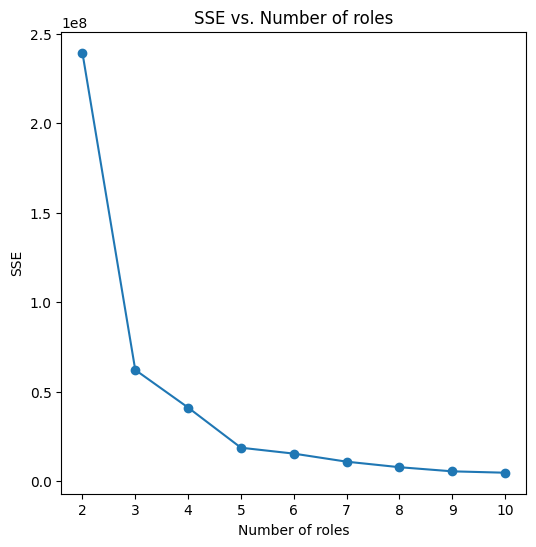

In [129]:

def find_best_n_roles(features, min_roles=2, max_roles=10):
    sse = []
    for n_roles in range(min_roles, max_roles + 1):
        kmeans = KMeans(n_clusters=n_roles, random_state=42)
        roles = kmeans.fit_predict(features)
        sse.append(kmeans.inertia_)  # SSE
    
    plt.figure(figsize=(6, 6))
    
    plt.plot(range(min_roles, max_roles + 1), sse, marker='o')
    plt.xlabel('Number of roles')
    plt.ylabel('SSE')
    plt.title('SSE vs. Number of roles')

    plt.savefig('sse.jpg', format='jpg', dpi=300)
    plt.show()


# Find the optimal number of roles
find_best_n_roles(features, min_roles=2, max_roles=10)


In [130]:
import pandas as pd
feature_names = ['degree','egonet_size','egonet_num_edges','egonet_avg_degree','egonet_avg_clustering']

features = pd.DataFrame(features,index=nodes, columns= feature_names)
# features


In [131]:
# Role extractor
role_extractor = RoleExtractor(n_roles=3)
roles = role_extractor.extract_role_factors(features)
node_roles = role_extractor.roles


In [133]:
role_percentage = role_extractor.role_percentage
role_feature_matrix = role_extractor.role_feature_factor

,role_0,role_1,role_2
0,0.333333,0.333333,0.333333
1,0.333333,0.333333,0.333333
12,0.333333,0.333333,0.333333
25,0.333333,0.333333,0.333333
26,0.333333,0.333333,0.333333
...,...,...,...
37555,0.704490,0.263811,0.031698
37613,0.024753,0.950494,0.024753
37617,0.333333,0.333333,0.333333
37636,0.950494,0.024753,0.024753


In [134]:
# Adds role assignment results to the feature data
features['role'] = features.index.map(node_roles)

# Get the Role_Feature Matrix
role_features = features.groupby('role').agg(['mean'])
role_features.columns = role_features.columns.droplevel(1)
role_features

,degree,egonet_size,egonet_num_edges,egonet_avg_degree,egonet_avg_clustering
role,,,,,
role_0,49.095541,50.095541,113.629761,2.871269,0.346822
role_1,198.679204,199.679204,661.937292,5.682854,0.486233
role_2,302.074074,303.074074,906.129630,4.112011,0.326427


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22284\2020193235.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_degree_egosize['role'] = features_degree_egosize.index.map(node_roles)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22284\2020193235.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  box_plot.set_xticklabels(['degree', 'egonet size'])


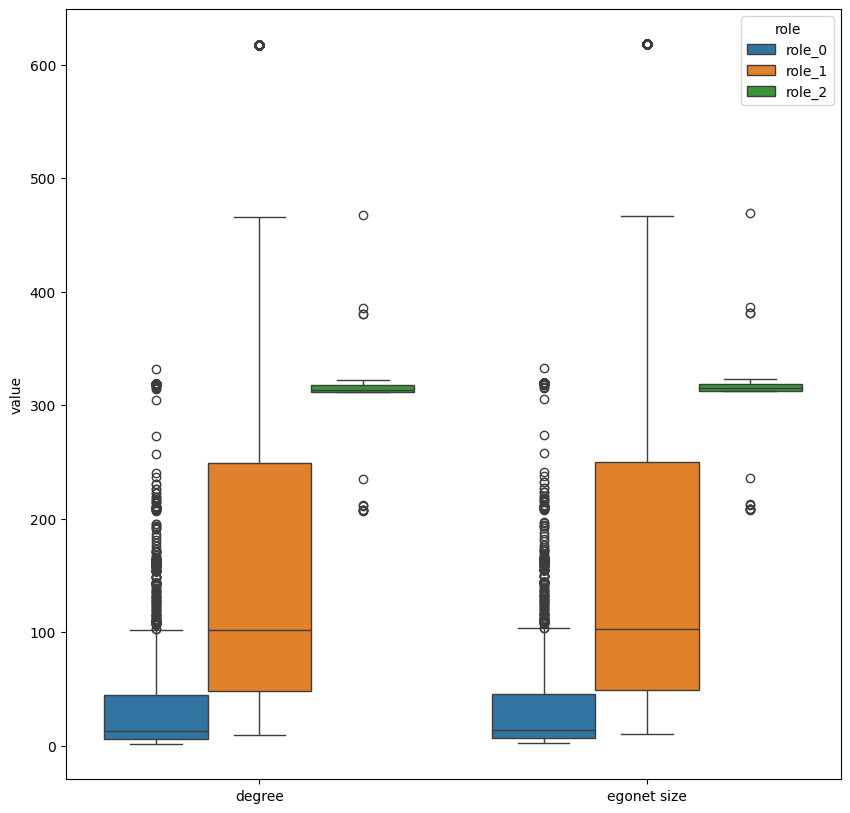

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22284\2020193235.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  box_plot.set_xticklabels(['Egonet_Edges'])


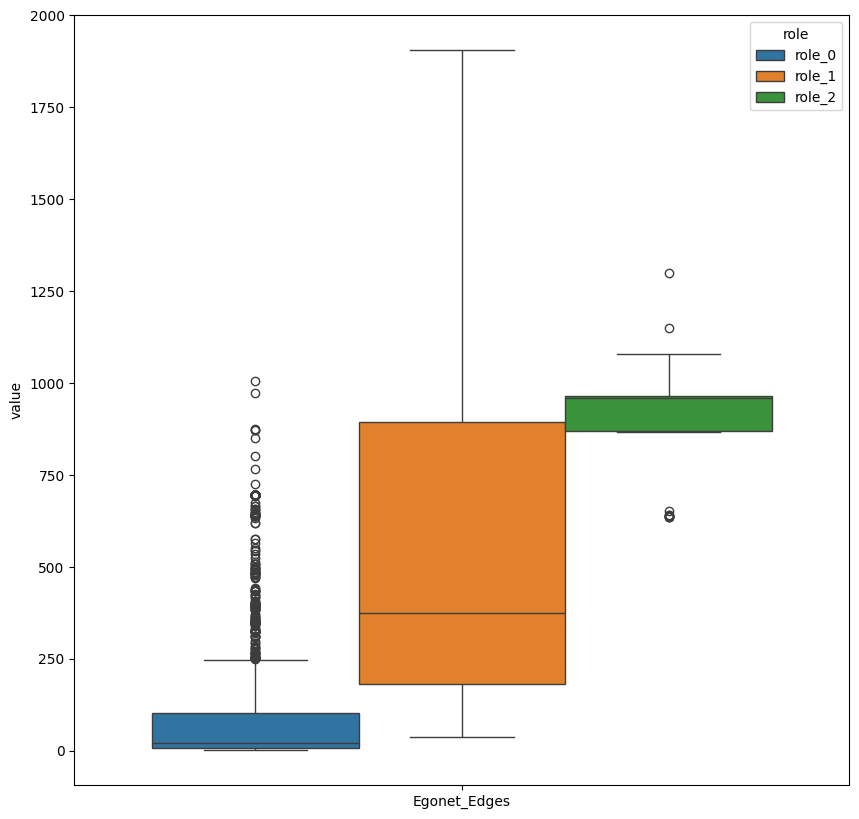

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22284\2020193235.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  box_plot.set_xticklabels(['Egonet_avg_degree'])


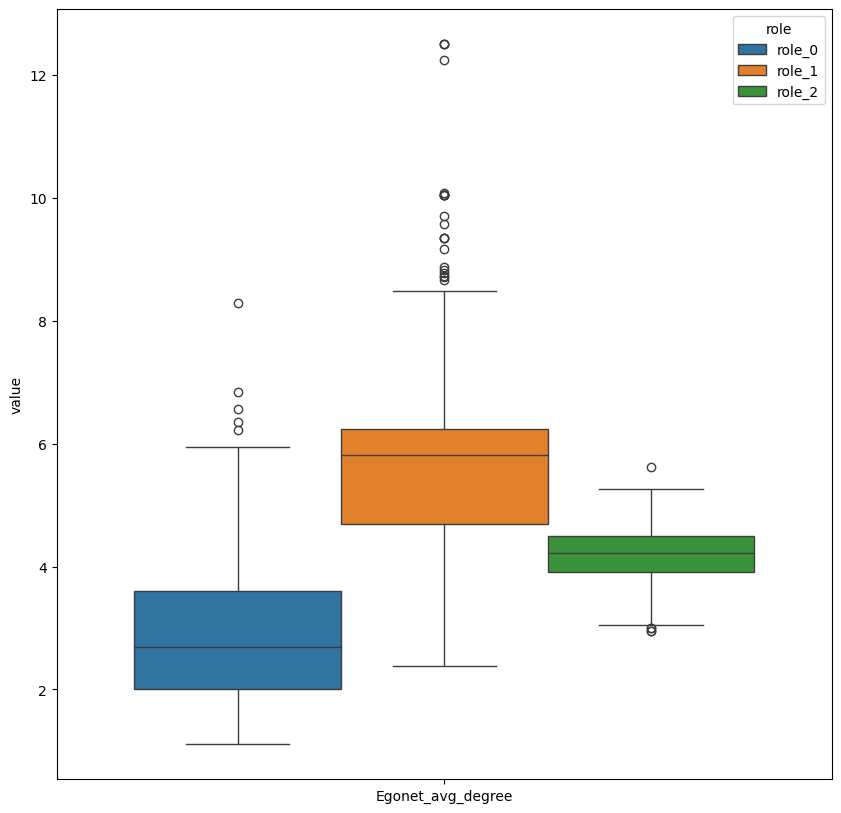

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22284\2020193235.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  box_plot.set_xticklabels(['Egonet_avg_clustering'])


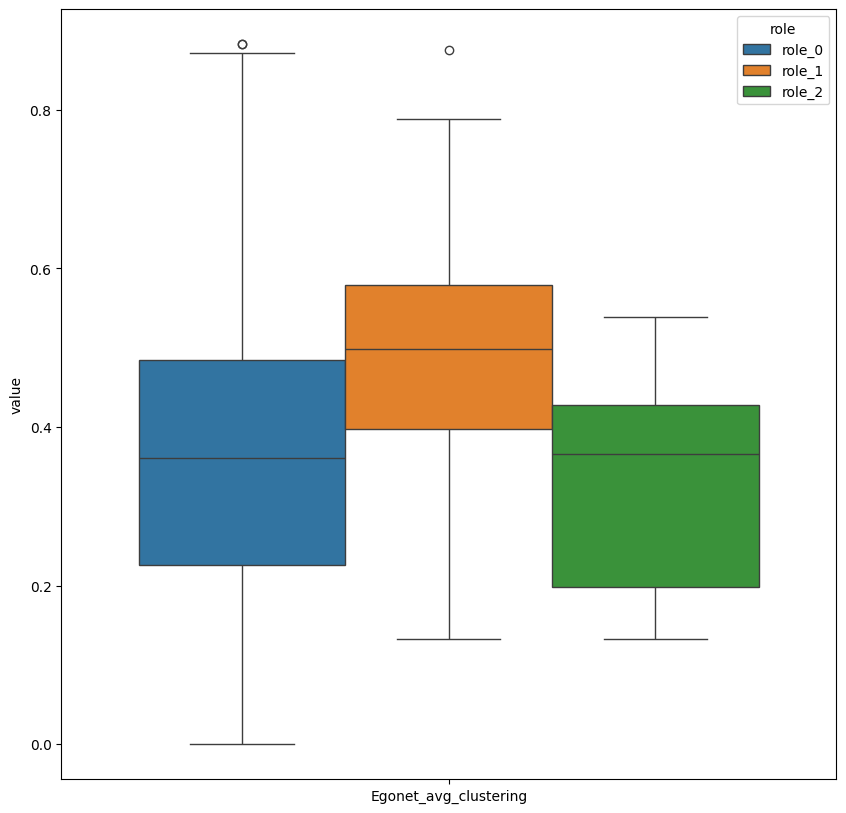

In [145]:
# Melt the matrix for plotting
features_degree_egosize = features.iloc[:, :2]
features_egonet_edges = features.iloc[:,2]
features_ego_avg_degree = features.iloc[:,3]
features_edgo_avg_clustering = features.iloc[:,4:]

features_egonet_edges = pd.DataFrame(features_egonet_edges)
features_ego_avg_degree = pd.DataFrame(features_ego_avg_degree)

features_degree_egosize['role'] = features_degree_egosize.index.map(node_roles)
features_ego_avg_degree['role'] = features_ego_avg_degree.index.map(node_roles)
features_egonet_edges['role'] = features_egonet_edges.index.map(node_roles)

# Melted DataFrame for the first three features
melted_degree_egosize = features_degree_egosize.melt(id_vars=['role'], var_name='feature', value_name='value')
melted_egonet_edges = features_egonet_edges.melt(id_vars=['role'], var_name='feature', value_name='value')
# Melted DataFrame for the last two features
melted_ego_avg_degree = features_ego_avg_degree.melt(id_vars=['role'], var_name='feature', value_name='value')
melted_ego_avg_clustering = features_edgo_avg_clustering.melt(id_vars = ['role'],var_name='feature', value_name='value')

# Visulazation
plt.figure(figsize=(10, 10))
box_plot = sns.boxplot(x = 'feature',y='value', hue='role', data= melted_degree_egosize)
box_plot.set_xticklabels(['degree', 'egonet size'])
box_plot.set_xlabel('')
plt.savefig('Degree & Egonet_size.jpg', format='jpg', dpi=300)
plt.show()

plt.figure(figsize=(10, 10))
box_plot = sns.boxplot(x = 'feature',y='value', hue='role', data= melted_egonet_edges)
box_plot.set_xticklabels(['Egonet_Edges'])
box_plot.set_xlabel('')
plt.savefig('Egonet_Edges.jpg', format='jpg', dpi=300)
plt.show()

plt.figure(figsize=(10, 10))
box_plot = sns.boxplot(x = 'feature',y='value', hue='role', data=melted_ego_avg_degree)
box_plot.set_xticklabels(['Egonet_avg_degree'])
box_plot.set_xlabel('')
plt.savefig('Egonet_avg_degree.jpg', format='jpg', dpi=300)
plt.show()

plt.figure(figsize=(10, 10))
box_plot = sns.boxplot(x = 'feature',y='value', hue='role', data=melted_ego_avg_clustering)
box_plot.set_xticklabels(['Egonet_avg_clustering'])
box_plot.set_xlabel('')
plt.savefig('Egonet_avg_clustering.jpg', format='jpg', dpi=300)
plt.show()

role_0    2059
role_1     952
role_2      36
dtype: int64


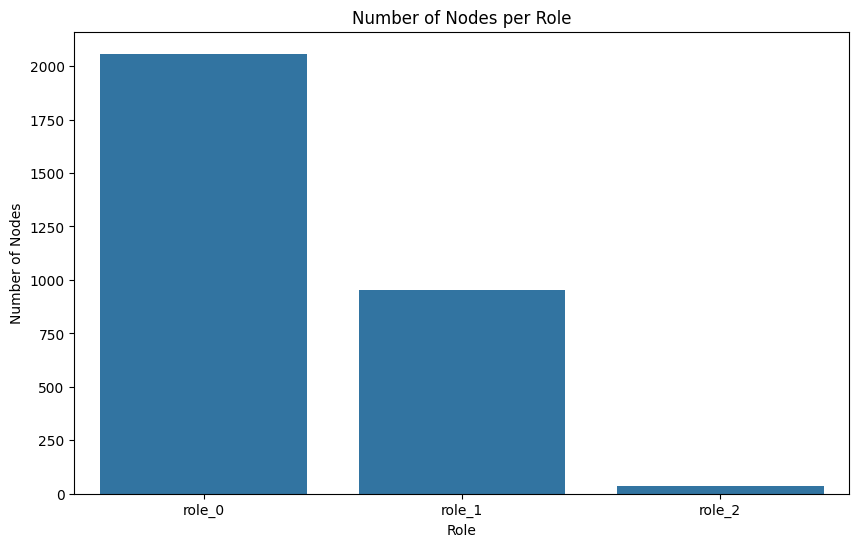

In [88]:
import pandas as pd
# Compute the number of node
role_counts = pd.Series(node_roles).value_counts()
print(role_counts)

# Visulazation
plt.figure(figsize=(10, 6))
sns.barplot(x=role_counts.index, y=role_counts.values)
plt.xlabel('Role')
plt.ylabel('Number of Nodes')
plt.title('Number of Nodes per Role')
plt.savefig('number_of_role.jpg', format='jpg', dpi=300)
plt.show()

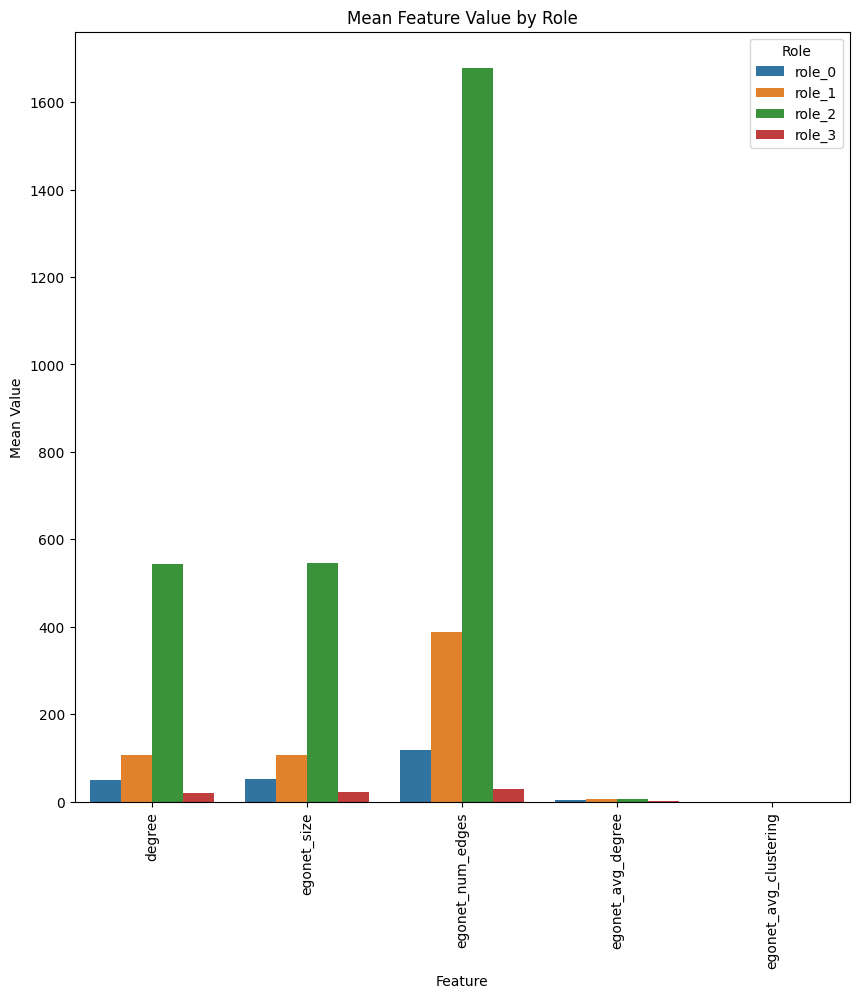

In [78]:
# Add role assignment results to the feature data
features['role'] = features.index.map(node_roles)

# Calculate the mean of each character's features
role_means = features.groupby('role').mean().reset_index()

melted_means = role_means.melt(id_vars=['role'], var_name='feature', value_name='mean_value')

# Draw bar charts
plt.figure(figsize=(10, 10))
sns.barplot(x='feature', y='mean_value', hue='role', data=melted_means)
plt.xticks(rotation=90)
plt.title('Mean Feature Value by Role')
plt.xlabel('Feature')
plt.ylabel('Mean Value')
plt.legend(title='Role')
plt.show()

In [96]:
# Create color and shape maps
unique_roles = sorted(set(node_roles.values()))
color_map = ['blue', 'green', 'red','grey','yellow']
shape_map = ['o', 's', '^','D','p']  

# Map characters to colors and shapes
role_colors = {role: color_map[i] for i, role in enumerate(unique_roles)}
role_shapes = {role: shape_map[i] for i, role in enumerate(unique_roles)}

role_colors


{'role_0': 'blue', 'role_1': 'green', 'role_2': 'red'}

In [89]:
# Create subsets for nodes of each role type
node_subsets = {shape: [node for node in sub_graph.nodes() if role_shapes[node_roles[node]] == shape] for shape in shape_map}


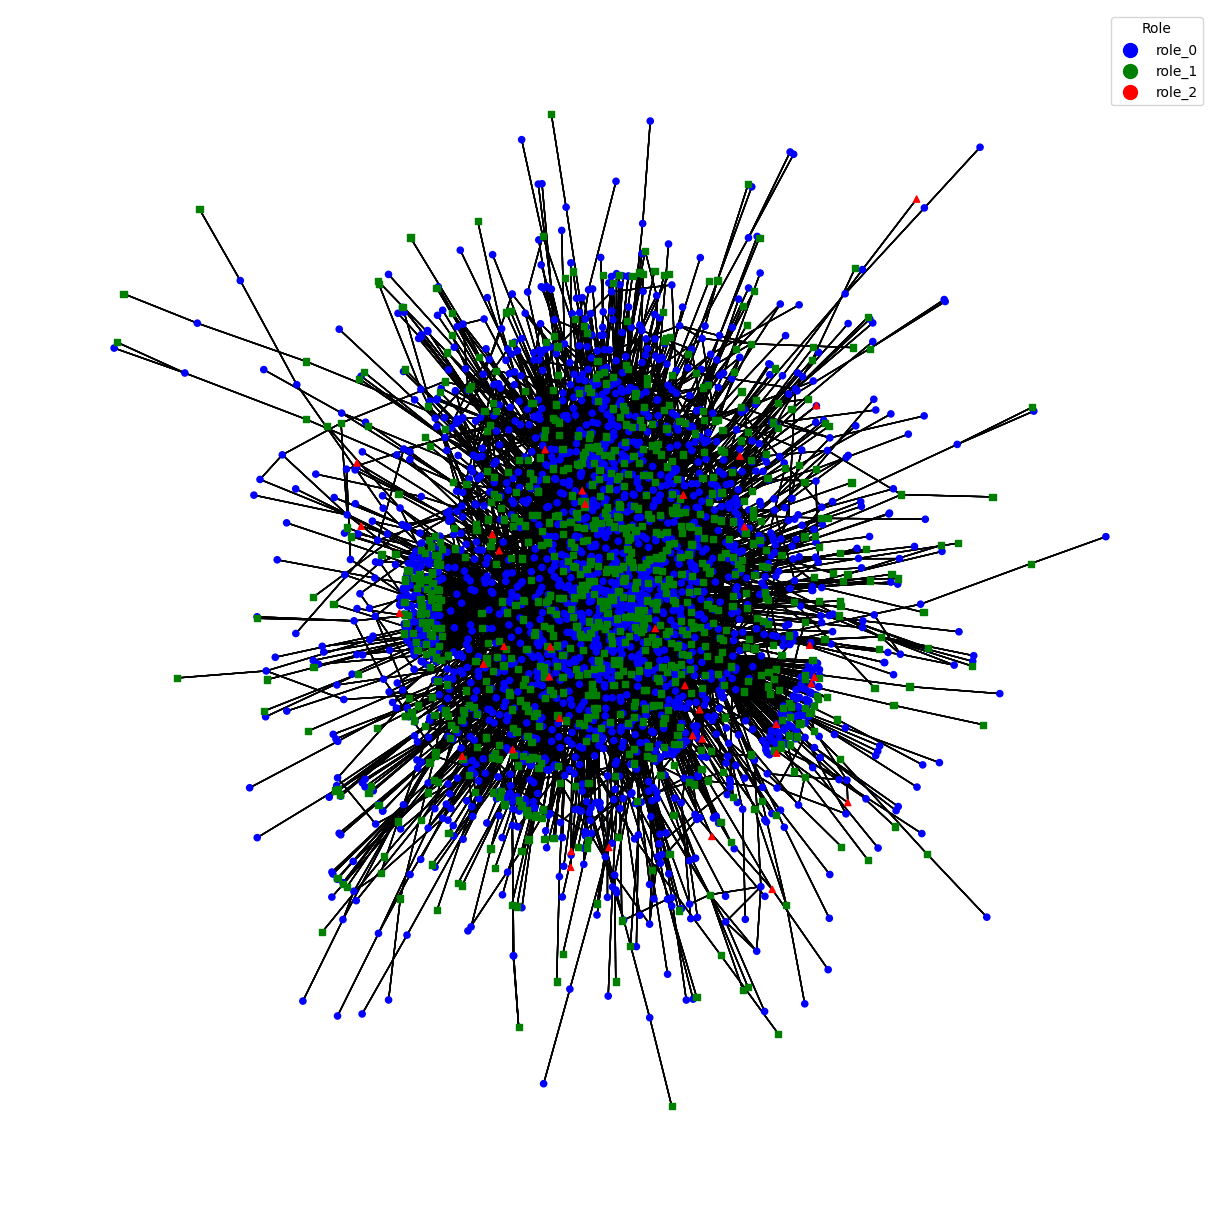

In [147]:

plt.figure(figsize=(12,12))


for shape, nodes in node_subsets.items():
    nx.draw(
        sub_graph,
        pos,
        nodelist=nodes,
        node_color=[role_colors[node_roles[node]] for node in nodes],
        node_shape=shape,
        node_size=20,  
        label={role: role for role in set(node_roles.values())} 
    )


# Add legend
plt.legend(title='Role', handles=[plt.Line2D([0], [0],marker= 'o',color=color, label=role, markersize=10, linestyle='None')
                                  for role, color in role_colors.items()])
 #nx.draw_networkx_edges(sub_graph, pos, alpha=0.5)
plt.savefig('Role Extraction.jpg', format='jpg', dpi=300)                                 
plt.show()
#plt.savefig('Role Extraction.jpg', format='jpg', dpi=300)


## Link Prediction

In [148]:
# Import basic node feature
with open('./git_web_ml/musae_git_features.json', 'r') as file:
    json_data = json.load(file)


In [149]:
sub_node = [str(node) for node in sub_graph.nodes()]
sub_data = {key: value for key, value in json_data.items() if key in sub_node}

In [150]:
# LabelEncoder for role
label_encoder = LabelEncoder()

# Converts a role to a number
numeric_roles = label_encoder.fit_transform([node_roles[node] for node in sub_graph.nodes()])
node_features = {node: numeric_roles[i] for i, node in enumerate(sub_graph.nodes())}



In [174]:
# Feature matrix with roles
def compute_features_roles(json_data,numeric_roles):
    
    features = np.zeros((len(json_data), 4))
    for i, (key, value) in enumerate(json_data.items()):
        for j in range(3):
            features[i][j] = value[j]

        features[i][3] = numeric_roles[i]
    
    return features

In [171]:
#Feature Matrix without roles
def compute_features(json_data,numeric_roles):
    
    features = np.zeros((len(json_data), 3))
    for i, (key, value) in enumerate(json_data.items()):
        for j in range(3):
            features[i][j] = value[j]
    
    return features

In [175]:
# Generated feature vector
def generate_features(node1, node2, features, sorted_nodes):
    idx1 = sorted_nodes.index(node1)
    idx2 = sorted_nodes.index(node2)
    return np.concatenate((features[idx1,:], features[idx2,:]))

In [176]:
features_link_roles =  compute_features_roles(sub_data, numeric_roles)
features_link = compute_features(sub_data,numeric_roles)

edges = list(sub_graph.edges())
non_edges = list(nx.non_edges(sub_graph))
sorted_nodes = sorted(sub_graph.nodes())


In [108]:
## Dataset for model with roles
# Positive and Negative samples
positive_samples = edges
negative_samples = random.sample(non_edges, len(positive_samples))

# label
positive_labels = [1] * len(positive_samples)
negative_labels = [0] * len(negative_samples)

# merge
positive_features_roles = [generate_features(edge[0], edge[1], features_link_roles, sorted_nodes) for edge in positive_samples]
negative_features_roles = [generate_features(edge[0], edge[1], features_link_roles, sorted_nodes) for edge in negative_samples]

X_roles = np.array(positive_features_roles + negative_features_roles)
y_roles = np.array(positive_labels + negative_labels)

# spilt training and testing set
X_roles_train, X_roles_test, y_roles_train, y_roles_test = train_test_split(X_roles, y_roles, test_size=0.2, random_state=42)

In [109]:
#Dataset for model without set
positive_features = [generate_features(edge[0], edge[1], features_link, sorted_nodes) for edge in positive_samples]
negative_features = [generate_features(edge[0], edge[1], features_link, sorted_nodes) for edge in negative_samples]


X = np.array(positive_features + negative_features)
y = np.array(positive_labels + negative_labels)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
# Initial-model with roles
model_roles = RandomForestClassifier(n_estimators=100, random_state=42)


model_roles.fit(X_roles_train, y_roles_train)
y_roles_pred = model_roles.predict(X_roles_test)
y_roles_proba = model_roles.predict_proba(X_roles_test)[:, 1]

In [111]:
# Model without roles
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_proba = model.predict_proba(X_test)[:, 1]

Accuracy: 0.6623
Precision: 0.6828
Recall: 0.5941
F1 Score: 0.6354
ROC AUC: 0.7095
log loss: 0.6234


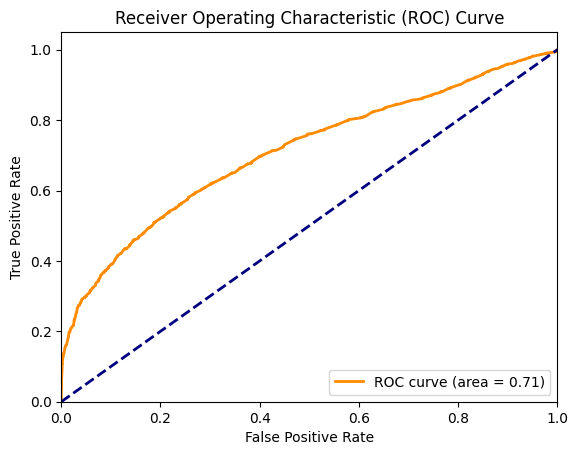

In [185]:

# Evaluate: Model with roles
accuracy = accuracy_score(y_roles_test, y_roles_pred)
precision = precision_score(y_roles_test, y_roles_pred)
recall = recall_score(y_roles_test, y_roles_pred)
f1 = f1_score(y_roles_test, y_roles_pred)
roc_auc = roc_auc_score(y_roles_test, y_roles_proba)
log_loss_value = log_loss(y_roles_test, y_roles_proba)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'log loss: {log_loss_value:.4f}')


fpr, tpr, _ = roc_curve(y_roles_test, y_roles_proba)
role_model_scores = [accuracy, precision, recall, f1, roc_auc,log_loss_value]

# plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Accuracy: 0.6332
Precision: 0.6416
Recall: 0.5875
F1 Score: 0.6134
ROC AUC: 0.6735
log loss: 0.7304


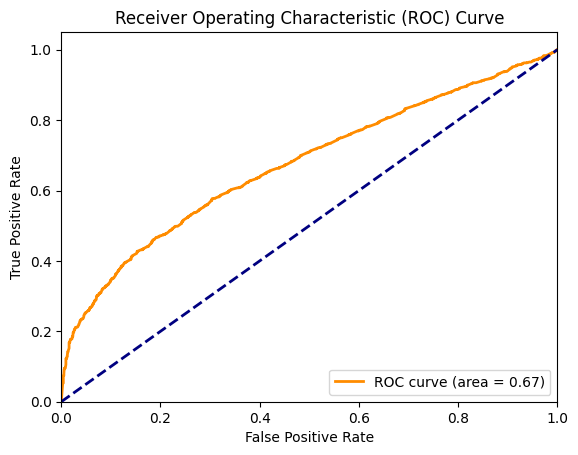

In [186]:
# Model without role
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
log_loss_value = log_loss(y_test, y_proba)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'log loss: {log_loss_value:.4f}')


fpr, tpr, _ = roc_curve(y_test, y_proba)
base_model_score = [accuracy, precision, recall, f1, roc_auc,log_loss_value]

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

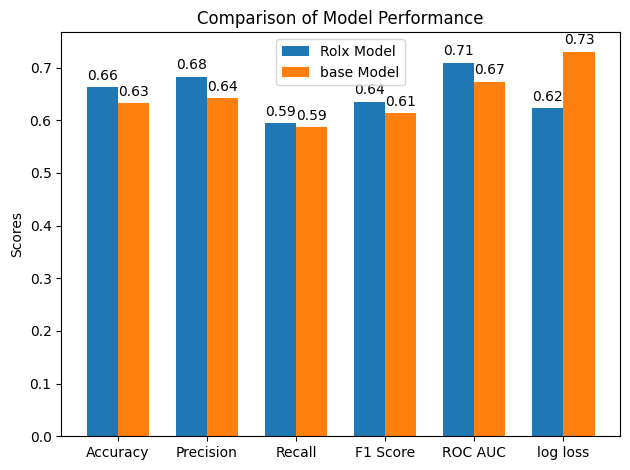

In [187]:
#Comparison
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC','log loss']
x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, role_model_scores, width, label='Rolx Model')
rects2 = ax.bar(x + width/2, base_model_score, width, label='base Model')


ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('Link_prediction.jpg', format='jpg', dpi=300)
plt.show()
